In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import PIL.ImageOps
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F 

In [2]:
folder_dataset = datasets.ImageFolder(root = "C:/Users/BHARATH/Downloads/at&t/data/faces/training")

* Folder dataset contains 373 images of 40 individuals, 10 images each for 37 people and 1 image each for the remaining 3.

In [3]:
print(len(folder_dataset))
print(type(folder_dataset[0]))
print(type(folder_dataset[0][0]))
print(type(folder_dataset[0][1]))

373
<class 'tuple'>
<class 'PIL.Image.Image'>
<class 'int'>


torch.Size([3, 100, 100])


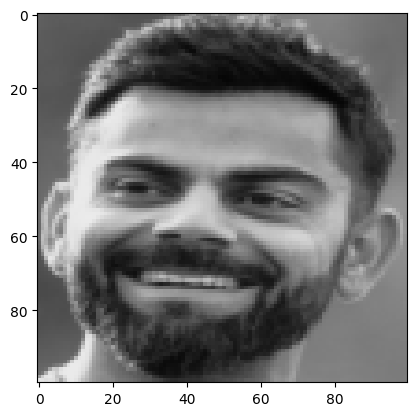

In [4]:
transform = transforms.Compose([transforms.Resize((100, 100)), transforms.PILToTensor()])
x = folder_dataset[351][0]
x = transform(x)
print(x.shape)
plt.imshow(x.permute(1,2,0))

In [5]:
image_from_each_class = []
prev = -1
for (i, l) in folder_dataset:
    if(l == prev + 1):
        image_from_each_class.append(transform(i)[0].unsqueeze(0).unsqueeze(0))
        prev = prev + 1
print(len(image_from_each_class),",", image_from_each_class[0].shape)

40 , torch.Size([1, 1, 100, 100])


In [6]:
import random
class req_dataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform
    def __getitem__(self, index):
        tuple1 = random.choice(self.dataset.imgs)
        should_get_same_class = random.randint(0, 1)
        if(should_get_same_class):
            while True:
                tuple2 = random.choice(self.dataset.imgs)
                if(tuple2[1] == tuple1[1]):
                    break
        else:
            while True:
                tuple2 = random.choice(self.dataset.imgs)
                if(tuple2[1] != tuple1[1]):
                    break
        img1 = Image.open(tuple1[0])
        img2 = Image.open(tuple2[0])
        img1 = img1.convert("L")
        img2 = img2.convert("L")
        img1 = self.transform(img1)
        img2 = self.transform(img2)
        return img1, img2 , torch.from_numpy(np.array([int(tuple1[1] != tuple2[1])], dtype=np.float32))
    
    def __len__(self):
        return len(self.dataset.imgs)

In [7]:
req_data = req_dataset(folder_dataset, transform)

In [8]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(256, 384, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace = True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace = True),
            
            nn.Linear(256, 5)
        )
    def forward_once(self, x):
        x =  x.type(torch.float32)
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output
    
    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        
        return output1, output2
        

In [9]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin = 2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [10]:
train_dataloader = DataLoader(req_data,
                        shuffle=True,
                        batch_size= 32)
net = SiameseNetwork()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

In [11]:
counter = []
loss_history = [] 
iteration_number= 0

for epoch in range(100):

    for i, (img1, img2, label) in enumerate(train_dataloader, 0):

        optimizer.zero_grad()

        output1, output2 = net(img1, img2)

        loss_contrastive = criterion(output1, output2, label)

        loss_contrastive.backward()

        optimizer.step()

        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())



Epoch number 0
 Current loss 1.1205397844314575

Epoch number 0
 Current loss 0.42186877131462097

Epoch number 1
 Current loss 0.34749865531921387

Epoch number 1
 Current loss 0.5688872933387756

Epoch number 2
 Current loss 0.3703228533267975

Epoch number 2
 Current loss 0.30254536867141724

Epoch number 3
 Current loss 0.2890482246875763

Epoch number 3
 Current loss 0.21098639070987701

Epoch number 4
 Current loss 0.4733077883720398

Epoch number 4
 Current loss 0.26781198382377625

Epoch number 5
 Current loss 0.3122571110725403

Epoch number 5
 Current loss 0.24421600997447968

Epoch number 6
 Current loss 0.1598467230796814

Epoch number 6
 Current loss 0.3978578448295593

Epoch number 7
 Current loss 0.39408841729164124

Epoch number 7
 Current loss 0.2926405668258667

Epoch number 8
 Current loss 0.17019307613372803

Epoch number 8
 Current loss 0.140330970287323

Epoch number 9
 Current loss 0.2040291130542755

Epoch number 9
 Current loss 0.250643253326416

Epoch number 1

In [12]:
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

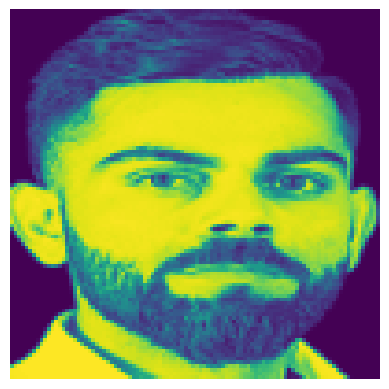

torch.Size([1, 1, 100, 100])


In [13]:
import cv2
image = cv2.imread("C:/Users/BHARATH/Downloads/sample_images/Virat-Kohli.png")
#C:/Users/BHARATH/Downloads/sample_images
image = Image.fromarray(image)
image = transform(image)
#image = image.squeeze(2)
image = image[0].unsqueeze(0)
imshow(image)
image = image.unsqueeze(0)
print(image.shape)

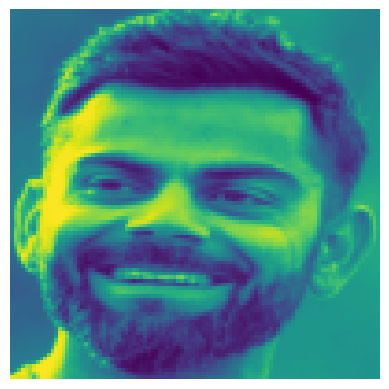

In [14]:
l = image_from_each_class.copy()
l = [F.pairwise_distance(*net(x, image)).item() for x in image_from_each_class]
imshow(image_from_each_class[np.argmin(l)].squeeze(0))